In [2]:
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark

     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 198 kB 54.0 MB/s 


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [176]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, year, quarter, lit, to_date, to_timestamp, concat, avg, mean
from pyspark.sql.types import IntegerType,BooleanType,DateType

In [6]:
import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

Loading the Dataset

# Loading the dataset

In [133]:
df = spark.read.csv("googleplaystore_1.csv", header=True, mode="DROPMALFORMED")
df2 = pd.read_csv("googleplaystore_1.csv", low_memory=False)

In [134]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)



In [72]:
df.show(5)

+--------------------+--------------+------+----+-------+--------+--------+
|                 App|      Category|Rating|Type|Reviews|    Size|Installs|
+--------------------+--------------+------+----+-------+--------+--------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|Free|    159|19000000|   10000|
| Coloring book moana|ART_AND_DESIGN|   3.9|Free|    967|14000000|  500000|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|Free|  87510| 8700000| 5000000|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5|Free| 215644|25000000|50000000|
|Pixel Draw - Numb...|ART_AND_DESIGN|   4.3|Free|    967| 2800000|  100000|
+--------------------+--------------+------+----+-------+--------+--------+
only showing top 5 rows



# Null Value Imputation

Checking and dealing Null values and changing DataTypes

In [135]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+--------+------+----+-------+----+--------+
|App|Category|Rating|Type|Reviews|Size|Installs|
+---+--------+------+----+-------+----+--------+
|  0|       0|  1468|   0|      0|3421|       0|
+---+--------+------+----+-------+----+--------+



In [136]:
df = df.withColumn("Rating",df.Rating.cast('float'))
df = df.withColumn("Reviews",df.Reviews.cast('int'))
df = df.withColumn("Size",df.Size.cast('int'))
df = df.withColumn("Installs",df.Installs.cast('int'))

In [137]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Type: string (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Installs: integer (nullable = true)



In [138]:
df.agg({'Rating': 'mean'}).show()

+-----------------+
|      avg(Rating)|
+-----------------+
|4.192521131842353|
+-----------------+



In [139]:
df = df.na.fill(value=4.2,subset=["Rating"])

In [140]:
df.agg({'Size': 'mean'}).show()

+--------------------+
|           avg(Size)|
+--------------------+
|2.0859639694761448E7|
+--------------------+



In [141]:
df = df.na.fill(value=20873023,subset=["Size"])

In [128]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+--------+------+----+-------+----+--------+
|App|Category|Rating|Type|Reviews|Size|Installs|
+---+--------+------+----+-------+----+--------+
|  0|       0|     0|   0|      0|   0|       0|
+---+--------+------+----+-------+----+--------+



# Exploratory Data Analysis

In [153]:
df.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
App,10694,None,None,"""""""i DT"""" Fútbol. Todos Somos Técnicos.""",🔥 Football Wallpapers 4K | Full HD Backgrounds 😍
Category,10694,None,None,ART_AND_DESIGN,WEATHER
Rating,10694,4.19354775410312,0.4797415438049876,1.0,5.0
Type,10694,None,None,Free,Paid
Reviews,10694,442123.73873199924,2943838.814208869,0,78158306
Size,10694,2.0863921000841595E7,1.8344216702698912E7,8500,100000000
Installs,10694,1.5393263463343931E7,8.550010864616987E7,0,1000000000


In [142]:
df4 = df.groupby('Category').count()

In [143]:
df4.sort(col('count').desc()).show()

+-------------------+-----+
|           Category|count|
+-------------------+-----+
|             FAMILY| 1969|
|               GAME| 1143|
|              TOOLS|  838|
|            MEDICAL|  463|
|           BUSINESS|  459|
|       PRODUCTIVITY|  424|
|    PERSONALIZATION|  391|
|      COMMUNICATION|  387|
|             SPORTS|  383|
|          LIFESTYLE|  381|
|               FICE|  366|
| HEALTH_AND_FITNESS|  340|
|             SOCIAL|  295|
| NEWS_AND_MAGAZINES|  283|
|           SHOPPING|  260|
|   TRAVEL_AND_LOCAL|  255|
|             DATING|  234|
|BOOKS_AND_REFERENCE|  231|
|        PHOTOGRAPHY|  231|
|      VIDEO_PLAYERS|  174|
+-------------------+-----+
only showing top 20 rows



In [144]:
df1 = df.toPandas()

In [22]:
y_val = df1['Category'].value_counts().index
x_val = df1['Category'].value_counts()
x_grph = []
y_grph = []
for i in range(len(x_val)):
    x_grph.append(x_val[i])
    y_grph.append(y_val[i])

Text(0.5, 1.0, ' Top Category in Google Play Store')

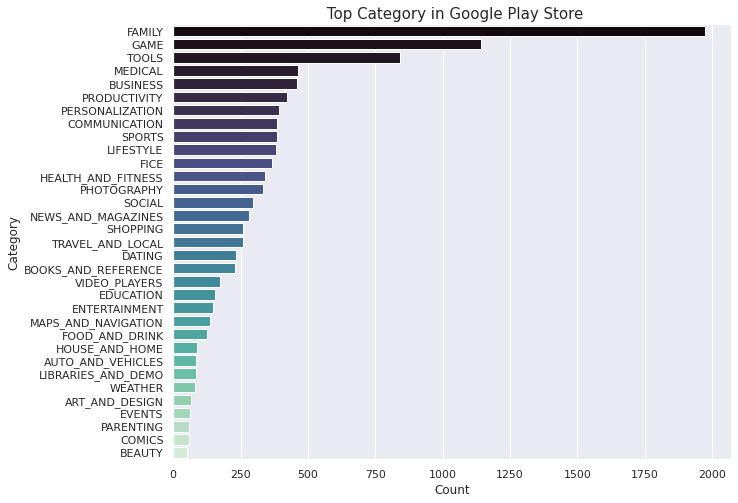

In [23]:
plt.figure(figsize=(10,8))
plt.xlabel("Count")
plt.ylabel("Category")
graph = sns.barplot(x = x_grph, y = y_grph, palette = "mako")
graph.set_title(" Top Category in Google Play Store", fontsize = 15)

In [107]:
df5 = df.groupby('Category').sum("Installs")
#df5.groupBy("Category").sum("Installs").sort(col="sum(Installs)").show()
df5.sort(col('sum(Installs)').desc()).show()

+-------------------+-------------+
|           Category|sum(Installs)|
+-------------------+-------------+
|               GAME|  35086024415|
|      COMMUNICATION|  32647276251|
|       PRODUCTIVITY|  14176091369|
|             SOCIAL|  14069867902|
|              TOOLS|  11452771915|
|             FAMILY|  10258263505|
|        PHOTOGRAPHY|  10088247655|
| NEWS_AND_MAGAZINES|   7496317760|
|   TRAVEL_AND_LOCAL|   6868887146|
|      VIDEO_PLAYERS|   6222002720|
|           SHOPPING|   3247848785|
|      ENTERTAINMENT|   2869160000|
|    PERSONALIZATION|   2325494782|
|BOOKS_AND_REFERENCE|   1921469576|
|             SPORTS|   1751174498|
| HEALTH_AND_FITNESS|   1582072512|
|           BUSINESS|   1001914865|
|               FICE|    876648734|
|          EDUCATION|    871452000|
|MAPS_AND_NAVIGATION|    719281890|
+-------------------+-------------+
only showing top 20 rows



In [25]:
most_install = df1.groupby('Category')[['Installs']].sum().sort_values(by = 'Installs', ascending = False)

In [26]:
x_inst =[]
y_inst =[]
for i in range (len(most_install)):
    x_inst.append(most_install.Installs[i])
    y_inst.append(most_install.index[i])  

Text(0.5, 1.0, ' Installs of Different Category')

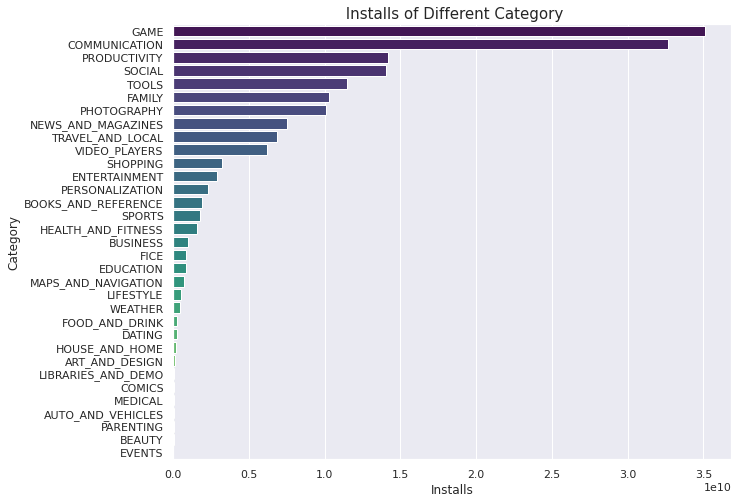

In [27]:
plt.figure(figsize=(10,8))
plt.xlabel("Installs")
plt.ylabel("Category")
graph = sns.barplot(x = x_inst, y = y_inst, palette = "viridis")
graph.set_title(" Installs of Different Category", fontsize = 15)

In [41]:
most_rev = df1.sort_values(by = 'Reviews', ascending = False).head(20)


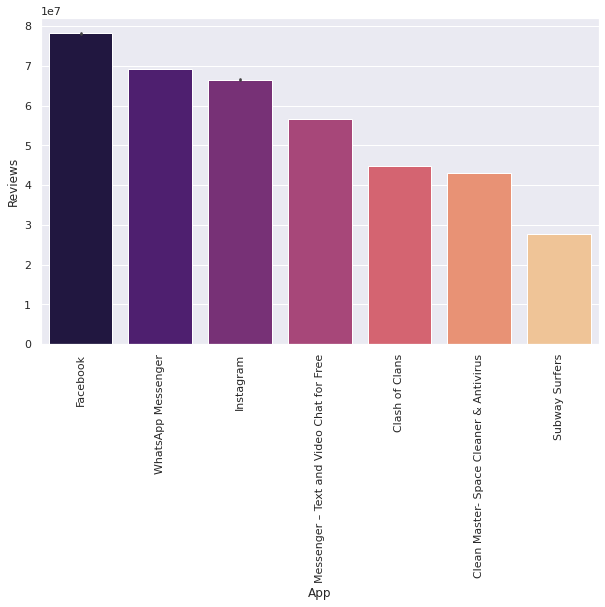

In [42]:
plt.figure(figsize = (10,6))
plt.xticks(rotation = 90)
plt.ylabel("Reviews")
sns.barplot(most_rev['App'], most_rev['Reviews'], palette = "magma")
plt.show()

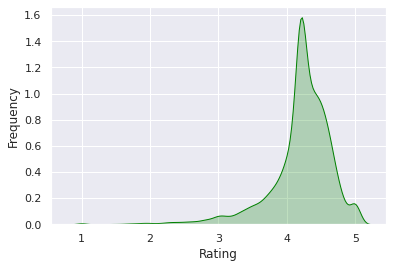

In [49]:
plt.figure(figsize=(6,4))
plt.xlabel("Rating")
plt.ylabel("Frequency")
graph = sns.kdeplot(df1.Rating, color = "Green", shade = True)
plt.show()

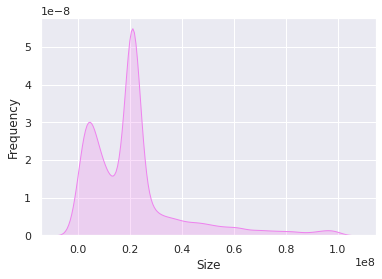

In [51]:
plt.figure(figsize=(6,4))
plt.xlabel("Size")
plt.ylabel("Frequency")
graph = sns.kdeplot(df1.Size, color = "Violet", shade = True)
plt.show()

In [54]:
index = StringIndexer(inputCol="Category", outputCol="Category_Levels")
temp_sdf = index.fit(df).transform(df)
df2 = temp_sdf.withColumn("Category_Levels", temp_sdf["Category_Levels"].cast("integer"))
df2.show(10)

+--------------------+--------------+------+-------+--------+--------+---------------+
|                 App|      Category|Rating|Reviews|    Size|Installs|Category_Levels|
+--------------------+--------------+------+-------+--------+--------+---------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159|19000000|   10000|             28|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967|14000000|  500000|             28|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510| 8700000| 5000000|             28|
|Sketch - Draw & P...|ART_AND_DESIGN|   4.5| 215644|25000000|50000000|             28|
|Pixel Draw - Numb...|ART_AND_DESIGN|   4.3|    967| 2800000|  100000|             28|
|Paper flowers ins...|ART_AND_DESIGN|   4.4|    167| 5600000|   50000|             28|
|Smoke Effect Phot...|ART_AND_DESIGN|   3.8|    178|19000000|   50000|             28|
|    Infinite Painter|ART_AND_DESIGN|   4.1|  36815|29000000| 1000000|             28|
|Garden Coloring Book|ART_AND_DESIGN|   4.4

In [145]:
df7 = df.groupby('Type').count()
df7.show()

+----+-----+
|Type|count|
+----+-----+
|Free| 9900|
|Paid|  794|
+----+-----+



[Text(0, 0, 'Free'), Text(0, 0, 'Paid')]

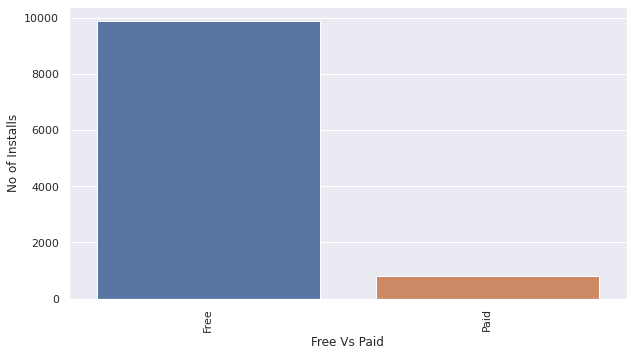

In [146]:
temp = df7.toPandas()
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
s0 = sns.barplot(x="Type", y="count", data=temp)
s0.set(xlabel='Free Vs Paid',ylabel='No of Installs')
s0.set_xticklabels(s0.get_xticklabels(),rotation=90)

In [151]:
size = df1[[ "Type", "Size", "Installs"]]
size["Log_Installs"] = np.log2(size["Installs"])
size.sample(n=6)

,Type,Size,Installs,Log_Installs
10242,Free,20873023,10000000,23.253497
2124,Free,25000000,1000000,19.931569
220,Free,15000000,1000000,19.931569
5298,Free,31000000,5000000,22.253497
8156,Paid,6200000,50,5.643856
4221,Free,20873023,100000000,26.575425


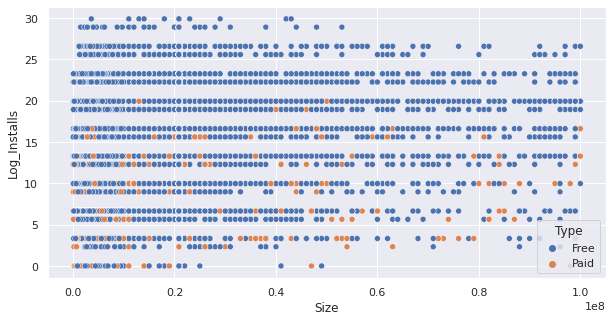

In [152]:
plt.figure(figsize=(10,5))
sns.scatterplot("Size", "Log_Installs", hue = "Type", data = size )
plt.show()

# Modelling

In [149]:
new_df = df.drop("Category")
new_df = df.drop("Type")

In [154]:
splits = new_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [157]:
import six
for i in new_df.columns:
    if not( isinstance(new_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Rating for ", i, new_df.stat.corr('Rating',i))

Correlation to Rating for  Rating 1.0
Correlation to Rating for  Reviews 0.0668291066003184
Correlation to Rating for  Size 0.027528702334533958
Correlation to Rating for  Installs 0.04971756503076949


In [158]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Installs','Size','Reviews'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(new_df)
vhouse_df = vhouse_df.select(['features', 'Rating'])
vhouse_df.show(3)

+--------------------+------+
|            features|Rating|
+--------------------+------+
|[500000.0,1.4E7,9...|   3.9|
|[5000000.0,870000...|   4.7|
|[5.0E7,2.5E7,2156...|   4.5|
+--------------------+------+
only showing top 3 rows



In [164]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [165]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Rating', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

In [166]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0]
Intercept: 4.192172054491016


In [167]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.480013
r2: -0.000000


In [170]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Rating')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="Rating", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.454573


In [172]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Rating', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'Rating', 'features').show(5)

+-----------------+------+--------------------+
|       prediction|Rating|            features|
+-----------------+------+--------------------+
|4.211389147076667|   4.2| [0.0,6700000.0,0.0]|
|4.211389147076667|   4.2| [0.0,8400000.0,0.0]|
|4.211389147076667|   4.2| [0.0,9400000.0,0.0]|
|4.201602737029567|   4.2|[0.0,2.0873023E7,...|
|4.201602737029567|   4.2|[0.0,2.0873023E7,...|
+-----------------+------+--------------------+
only showing top 5 rows



In [175]:
gbt_evaluator = RegressionEvaluator(labelCol="Rating", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.451375
